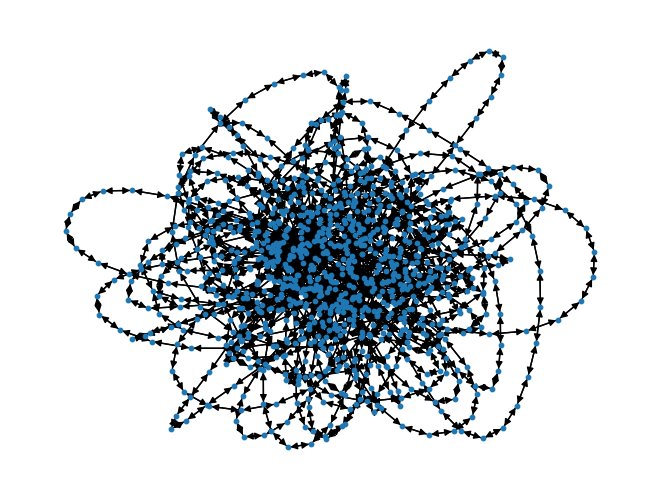

Top 10 pages by PageRank:
Page 26: 0.006407657877419998
Page 42: 0.006309533820480254
Page 425: 0.00630924531208407
Page 128: 0.006209825203446937
Page 762: 0.006076218993855884
Page 13: 0.00575856410999918
Page 207: 0.005102287075441184
Page 529: 0.004891879661096934
Page 455: 0.004639536862101041
Page 617: 0.0044865330310695705


Correlation between node importance (PageRank) and node degree: 0.9899614498898186


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# generate directed graph
def generate_graph(n, min_degree, max_degree, power):
    degrees = np.random.zipf(power, n)
    degrees = np.clip(degrees, min_degree, max_degree)
    G = nx.configuration_model(degrees)
    # remove the repetitive(duplicate) edge
    G = nx.Graph(G)  
    # turn undirected graph to directed 
    graph = G.to_directed() 
    return graph

def page_rank(G, alpha):
    return nx.pagerank(G, alpha)

# Spam Farm with num_spam_pages
def spam_farm(G, num_spam_pages):
    spam_nodes = np.random.choice(G.nodes(), num_spam_pages, replace=False)
    return spam_nodes

# Plot graph
def plot_graph(G):
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=10)
    plt.show()

# generate graph with 1000 nodes, min_degree=2, max_degree=20, power=2.5
graph = generate_graph(n=1000, min_degree=2, max_degree=20, power=2.5)

plot_graph(graph)

pagerank = page_rank(graph, alpha=0.85)

# Top 10 pages by PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
print("Top 10 pages by PageRank:")
for i, (page, rank) in enumerate(sorted_pagerank[:10]):
    print(f"Page {page}: {rank}")

# Calculate the correlation between node PageRank and node degree
degrees = dict(graph.degree())
pageranks = np.array([pagerank[node] for node in graph.nodes()])
correlation = np.corrcoef(list(degrees.values()), pageranks)[0, 1]
print("\n")
print("Correlation between node importance (PageRank) and node degree:", correlation)

Target node 102


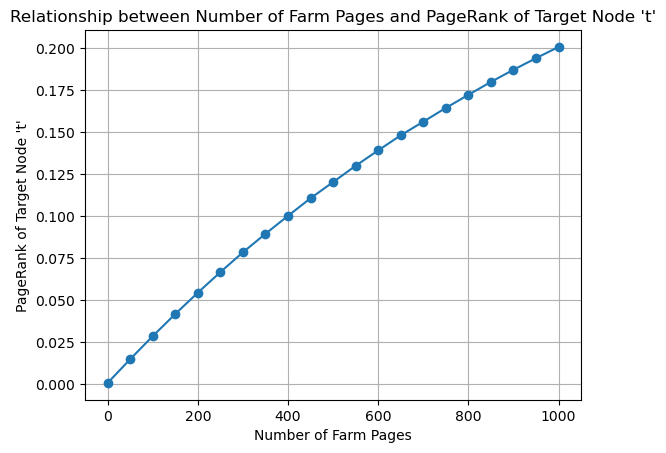

In [2]:
# Chose a random target node
np.random.seed(42)
target_node = np.random.choice(list(graph.nodes()))
print("Target node", target_node)

# define the range of number of spam pages
num_spam_pages_range = list(range(0, 1001, 50))

def compute_pagerank(graph, target_node, spam_farm_pages):
    # Add owned pages to the graph
    graph_spam_farm = graph.copy()
    
    edges = [(page, target_node) for page in spam_farm_pages]
    edges.extend([(target_node, page) for page in spam_farm_pages])  # Add reverse edges
    graph_spam_farm.add_edges_from(edges)
    
    pagerank = nx.pagerank(graph_spam_farm)
    
    return pagerank[target_node]

# Calculate the PageRank of the target node for different number of spam pages
pageranks = []
for num_spam_pages in num_spam_pages_range:
    # Generate spam farm
    spam_farm_pages = list(range(num_spam_pages))
    # Calculate PageRank of the target node
    pagerank_t = compute_pagerank(graph, target_node, spam_farm_pages)
    pageranks.append(pagerank_t)

# Plot the relationship between the number of spam pages and the PageRank of the target node
plt.plot(num_spam_pages_range, pageranks, marker='o')
plt.xlabel("Number of Farm Pages")
plt.ylabel("PageRank of Target Node 't'")
plt.title("Relationship between Number of Farm Pages and PageRank of Target Node 't'")
plt.grid(True)
plt.show()

In [3]:
from sklearn.linear_model import LinearRegression

x = np.array(num_spam_pages_range).reshape(-1, 1)  
y = np.array(pageranks)
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0]
print("Slope of regression line:", slope)

Slope of regression line: 0.0001978156631442786


In [4]:
def compute_trustrank_1(graph, trust_pages, damping_factor=0.85, max_iterations=100, tolerance=1.0e-8):
    # Trustrank computation logic here
    trustrank = {node: 1 for node in graph.nodes()}
    for _ in range(max_iterations):
        trustrank_new = {}
        for node in graph.nodes():
            if node in trust_pages:
                trustrank_new[node] = trustrank[node]
            else:
                trustrank_new[node] = (1 - damping_factor) / len(graph.nodes())
                for neighbor in graph.neighbors(node):
                    trustrank_new[node] += damping_factor * trustrank[neighbor] / len(list(graph.neighbors(neighbor)))
        diff = max(abs(trustrank_new[node] - trustrank[node]) for node in graph.nodes())
        if diff < tolerance:
            break
        trustrank = trustrank_new
    return trustrank

# Compute PageRank
def compute_pagerank(graph_spam_farm, trust_pages):
    # Calculate PageRank with trust pages
    pagerank_with_trust = nx.pagerank(graph_spam_farm, personalization=dict.fromkeys(trust_pages, 1))
    # Calculate PageRank without trust pages
    pagerank_without_trust = nx.pagerank(graph_spam_farm)
    return pagerank_with_trust, pagerank_without_trust

accessible_pages = list(graph.nodes()) 
accessible_pages.remove(target_node)
num_trust_pages = int(len(accessible_pages) * 0.05)
trust_pages = np.random.choice(accessible_pages, num_trust_pages, replace=False)

spam_masses = []
for num_spam_pages in num_spam_pages_range:
    # Combine the graph
    graph_spam_farm = graph.copy()
    spam_farm_pages = list(range(1000))
    spam_farm_pages = range(len(graph_spam_farm.nodes()), len(graph_spam_farm.nodes()) + num_spam_pages)
    edges = [(page, target_node) for page in spam_farm_pages]
    edges.extend([(target_node, page) for page in spam_farm_pages])  # Add reverse edges
    graph_spam_farm.add_edges_from(edges)
    
    trustrank = compute_trustrank_1(graph_spam_farm, trust_pages)
    # Calculate PageRank with and without trust pages
    pagerank_with_trust, pagerank_without_trust = compute_pagerank(graph_spam_farm, trust_pages)
    # Calculate Spam mass for the target node
    spam_mass = (pagerank_without_trust[target_node] - pagerank_with_trust[target_node]) / pagerank_without_trust[target_node]
    spam_masses.append(spam_mass)


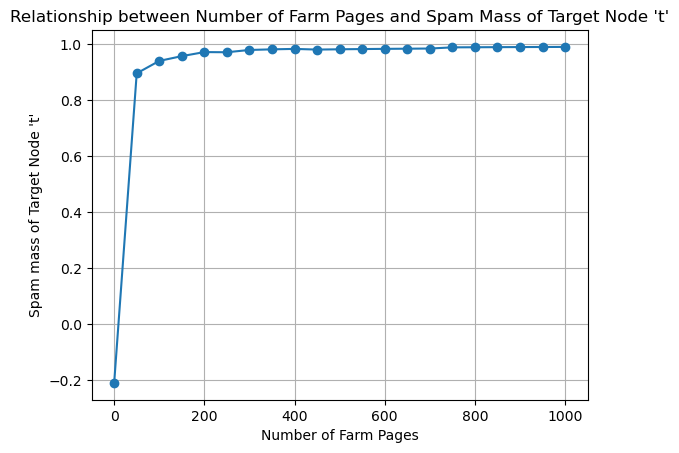

In [5]:
plt.plot(num_spam_pages_range, spam_masses, marker='o')
plt.xlabel("Number of Farm Pages")
plt.ylabel("Spam mass of Target Node 't'")
plt.title("Relationship between Number of Farm Pages and Spam Mass of Target Node 't'")
plt.grid(True)
plt.show()

In [7]:
# Calculate the PageRank of the target node for number of spam pages = 500
num_spam_pages_range = 500

# Create a copy of the graph
graph_spam_farm = graph.copy()

# Add 500 nodes to the graph connected to the target_node
spam_farm_pages = range(len(graph_spam_farm.nodes()), len(graph_spam_farm.nodes()) + num_spam_pages_range)
edges = [(page, target_node) for page in spam_farm_pages]
edges.extend([(target_node, page) for page in spam_farm_pages])  # Add reverse edges
graph_spam_farm.add_edges_from(edges)

trustrank = compute_trustrank_1(graph_spam_farm, trust_pages)
print("Trustrank:", trustrank)
for key, value in trustrank.items():
    print(f"{key}: {value}")

Trustrank: {0: 0.0037242954096468757, 1: 0.555825084709576, 2: 0.7793409038344918, 3: 0.536555114753505, 4: 0.1479997455255671, 5: 0.04338761775839325, 6: 0.05853985482794913, 7: 0.03478964215871088, 8: 0.162001533102881, 9: 0.07346421789703714, 10: 0.12812770478804525, 11: 0.2537726992667436, 12: 0.0500523457813305, 13: 1.0375899447421668, 14: 0.03363142297849865, 15: 0.006486154215012978, 16: 0.02974265487762416, 17: 0.09444275074066562, 18: 0.07391613169064364, 19: 0.009095914855762794, 20: 0.02579662810492703, 21: 0.024823649198329405, 22: 0.02583708796493211, 23: 0.0045427657951583236, 24: 0.35708817612281174, 25: 0.2849221413914828, 26: 1.5403148227492032, 27: 0.0804485301004961, 28: 0.04652202378320928, 29: 0.007067062664118062, 30: 0.316577931379168, 31: 0.03790152242650767, 32: 0.3747867637915626, 33: 0.10700623219705019, 34: 0.09400562875863408, 35: 0.03125355494593644, 36: 0.02702623117991943, 37: 0.5385865479511085, 38: 0.06713107166778257, 39: 0.16043558969464086, 40: 0.03